In [1]:
! git clone https://github.com/matale14/spai_dataset.git
  
#0 = W
#1 = G
#2 = B
#3 = M
#4 = A


"""
normalize images
mean / standard deviation



"""

Cloning into 'spai_dataset'...
remote: Enumerating objects: 5106, done.
remote: Total 5106 (delta 0), reused 0 (delta 0), pack-reused 5106
Receiving objects: 100% (5106/5106), 955.44 MiB | 33.69 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (5144/5144), done.


'\nnormalize images\nmean / standard deviation\n\n\n\n'

In [2]:
import os, pathlib


def rename(path):
    count = 0
    for filename in os.listdir(path):
          e = "{}/{}.{}".format(path, filename[:-4], "jpg")
          i = path + "/" + filename
          
          os.rename(i, e)
          count += 1
    print("changed",count, "file(s)!")


rename('spai_dataset/images/2')
rename('spai_dataset/images/3')
rename('spai_dataset/test')

changed 812 file(s)!
changed 807 file(s)!
changed 1057 file(s)!


Reading training images
Loading 2 files (Index: 0)
812 Files
Loading 4 files (Index: 1)
792 Files
Loading 0 files (Index: 2)
874 Files
Loading 3 files (Index: 3)
807 Files
Loading 1 files (Index: 4)
802 Files
Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		3270
Number of files in Validation-set:	817
layer_conv1 Tensor("Relu_4:0", shape=(?, 128, 128, 32), dtype=float32)
layer_conv2 Tensor("Relu_5:0", shape=(?, 64, 64, 32), dtype=float32)
layer_conv3 Tensor("Relu_6:0", shape=(?, 32, 32, 64), dtype=float32)
layer_flat Tensor("Reshape_1:0", shape=(?, 65536), dtype=float32)
layer_fc1 Tensor("Relu_7:0", shape=(?, 128), dtype=float32)
layer_fc2 Tensor("add_9:0", shape=(?, 5), dtype=float32)
Training Epoch 1 --- Training Accuracy:  37.5%, Validation Accuracy:  18.8%,  Validation Loss: 2.499
Saving model, higher accuracy
Training Epoch 2 --- Training Accuracy:  31.2%, Validation Accuracy:  25.0%,  Validation Loss: 1.545
Saving model, higher accuracy

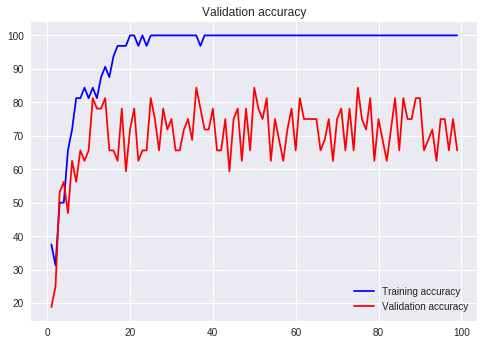

In [5]:
import tensorflow as tf
import time
from datetime import timedelta
import math
import random
import numpy as np
import os
import glob
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

  
def load_train(train_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:   # assuming data directory has a separate folder for each class, and that each folder is named after the class
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        print(len(files), "Files")
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            ids.append(flbase)
            cls.append(fld)
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)

    return images, labels, ids, cls


def load_test(test_path, image_size):
  path = os.path.join(test_path, '*g')
  files = sorted(glob.glob(path))

  X_test = []
  X_test_id = []
  print("Reading test images")
  for fl in files:
      flbase = os.path.basename(fl)
      img = cv2.imread(fl)
      img = cv2.resize(img, (image_size, image_size), cv2.INTER_LINEAR)
      X_test.append(img)
      X_test_id.append(flbase)

  ### because we're not creating a DataSet object for the test images, normalization happens here
  X_test = np.array(X_test, dtype=np.uint8)
  X_test = X_test.astype('float32')
  X_test = X_test / 255

  return X_test, X_test_id



class DataSet(object):

  def __init__(self, images, labels, ids, cls):
    """Construct a DataSet. one_hot arg is used only if fake_data is true."""

    self._num_examples = images.shape[0]


    # Convert shape from [num examples, rows, columns, depth]
    # to [num examples, rows*columns] (assuming depth == 1)
    # Convert from [0, 255] -> [0.0, 1.0].

    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)

    self._images = images
    self._labels = labels
    self._ids = ids
    self._cls = cls
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def ids(self):
    return self._ids

  @property
  def cls(self):
    return self._cls

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    self._index_in_epoch += batch_size

    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1

      # # Shuffle the data (maybe)
      # perm = np.arange(self._num_examples)
      # np.random.shuffle(perm)
      # self._images = self._images[perm]
      # self._labels = self._labels[perm]
      # Start next epoch

      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch

    return self._images[start:end], self._labels[start:end], self._ids[start:end], self._cls[start:end]


def read_train_sets(train_path, image_size, classes, validation_size=0):
  class DataSets(object):
    pass
  data_sets = DataSets()

  images, labels, ids, cls = load_train(train_path, image_size, classes)
  images, labels, ids, cls = shuffle(images, labels, ids, cls)  # shuffle the data

  if isinstance(validation_size, float):
    validation_size = int(validation_size * images.shape[0])

  validation_images = images[:validation_size]
  validation_labels = labels[:validation_size]
  validation_ids = ids[:validation_size]
  validation_cls = cls[:validation_size]

  train_images = images[validation_size:]
  train_labels = labels[validation_size:]
  train_ids = ids[validation_size:]
  train_cls = cls[validation_size:]

  data_sets.train = DataSet(train_images, train_labels, train_ids, train_cls)
  data_sets.valid = DataSet(validation_images, validation_labels, validation_ids, validation_cls)

  return data_sets


def read_test_set(test_path, image_size):
  images, ids  = load_test(test_path, image_size)
  return images, ids



#Adding Seed so that random initialization is consistent
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


batch_size = 32


#Prepare input data
classes = os.listdir('spai_dataset/images')
num_classes = len(classes)

# 20% of the data will automatically be used for validation
validation_size = 0.2
img_size = 256
num_channels = 3
train_path='spai_dataset/images'

# We shall load all the training and validation images and labels into memory using openCV and use that during training
data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)


print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(len(data.train.labels)))
print("Number of files in Validation-set:\t{}".format(len(data.valid.labels)))



session = tf.Session()
x = tf.placeholder(tf.float32, shape=[None, img_size,img_size,num_channels], name='x')

## labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)



##Network graph params
filter_size_conv1 = 3
num_filters_conv1 = 32

filter_size_conv2 = 3
num_filters_conv2 = 32

filter_size_conv3 = 3
num_filters_conv3 = 64

fc_layer_size = 128

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))



def create_convolutional_layer(input,
               num_input_channels,
               conv_filter_size,
               num_filters):

    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(num_filters)

    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

    layer += biases

    ## We shall be using max-pooling.
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
    ## Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)

    return layer



def create_flatten_layer(layer):
    #We know that the shape of the layer will be [batch_size img_size img_size num_channels]
    # But let's get it from the previous layer.
    layer_shape = layer.get_shape()

    ## Number of features will be img_height * img_width* num_channels. But we shall calculate it in place of hard-coding it.
    num_features = layer_shape[1:4].num_elements()

    ## Now, we Flatten the layer so we shall have to reshape to num_features
    layer = tf.reshape(layer, [-1, num_features])

    return layer


def create_fc_layer(input,
             num_inputs,
             num_outputs,
             use_relu=True):

    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)

    # Fully connected layer takes input x and produces wx+b.Since, these are matrices, we use matmul function in Tensorflow
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


layer_conv1 = create_convolutional_layer(input=x,
               num_input_channels=num_channels,
               conv_filter_size=filter_size_conv1,
               num_filters=num_filters_conv1)
print("layer_conv1", layer_conv1)
layer_conv2 = create_convolutional_layer(input=layer_conv1,
               num_input_channels=num_filters_conv1,
               conv_filter_size=filter_size_conv2,
               num_filters=num_filters_conv2)
print("layer_conv2", layer_conv2)
layer_conv3= create_convolutional_layer(input=layer_conv2,
               num_input_channels=num_filters_conv2,
               conv_filter_size=filter_size_conv3,
               num_filters=num_filters_conv3)
print("layer_conv3", layer_conv3)
layer_flat = create_flatten_layer(layer_conv3)
print("layer_flat", layer_flat)
layer_fc1 = create_fc_layer(input=layer_flat,
                     num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                     num_outputs=fc_layer_size,
                     use_relu=True)
print("layer_fc1", layer_fc1)
layer_fc2 = create_fc_layer(input=layer_fc1,
                     num_inputs=fc_layer_size,
                     num_outputs=num_classes,
                     use_relu=False)
print("layer_fc2", layer_fc2)

y_pred = tf.nn.softmax(layer_fc2,name='y_pred')

y_pred_cls = tf.argmax(y_pred, dimension=1)
session.run(tf.global_variables_initializer())
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                    labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


session.run(tf.global_variables_initializer())


def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))
    return([val_acc, val_loss, acc])

total_iterations = 0

saver = tf.train.Saver()
def train(num_iteration):
    old_acc = [0, 10]
    tra_history = []
    acc_history = []
    global total_iterations
    for i in range(total_iterations,
                   total_iterations + num_iteration):

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(batch_size)


        feed_dict_tr = {x: x_batch,
                           y_true: y_true_batch}
        feed_dict_val = {x: x_valid_batch,
                              y_true: y_valid_batch}

        session.run(optimizer, feed_dict=feed_dict_tr)

        if i % int(data.train.num_examples/batch_size) == 0:
            val_loss = session.run(cost, feed_dict=feed_dict_val)
            epoch = int(i / int(data.train.num_examples/batch_size))
            
            new_acc = show_progress(epoch, feed_dict_tr, feed_dict_val, val_loss)
            acc_history.append(new_acc[0]*100)
            tra_history.append(new_acc[2]*100)
            
            if new_acc[1] < old_acc[1] and new_acc[0] == old_acc[0]:
                old_acc[1] = new_acc[1]
                saver.save(session, 'model/spai_model')
                print("Saving model, higher accuracy")
                
            if new_acc[0] > old_acc[0]:
                old_acc[0] = new_acc[0]
                saver.save(session, 'model/spai_model')
                print("Saving model, higher accuracy")
                
    saver.save(session, 'model_final/spai_model')
    total_iterations += num_iteration
    
    #train and validation accuracy

    epochs = range(1, len(acc_history) +1)
    plt.plot(epochs, tra_history, "b", label = "Training accuracy")
    plt.plot(epochs, acc_history, "r", label = "Validation accuracy")
    plt.title("Validation accuracy")
    plt.legend()

train(num_iteration=10000)
print("Complete")

In [4]:
import tensorflow as tf
import numpy as np
import os,glob,cv2
import sys,argparse
import time, operator
from os import listdir
from os.path import isfile, join
import shutil


#0 = W
#1 = G
#2 = B
#3 = M
#4 = A

#the numbers above, are the folder numbers. the numbers below, are the training numbers
#have to match them

a_index = 1
g_index = 4
b_index = 0
w_index = 2
m_index = 3

"""
header = "class,picNum,picType"
lines = []
lines.append(header)
onlyfiles = [f for f in listdir('spai_dataset/test') if isfile(join('spai_dataset/','test/', f))]
for i in onlyfiles:

    if i[0] == 'W':
        i = i.strip('.jpg')
        string = "{},{},{}".format(w_index,i,'Wenche')
    elif i[0] == 'G':
        i = i.strip('.jpg')
        string = "{},{},{}".format(g_index,i,'Gabbi')
    elif i[0] == 'B':
        i = i.strip('.jpg')
        string = "{},{},{}".format(b_index,i,'Bjarke')
    elif i[0] == 'M':
        i = i.strip('.jpg')
        string = "{},{},{}".format(m_index,i,'Monica')
    elif i[0] == 'A':
        i = i.strip('.jpg')
        string = "{},{},{}".format(a_index,i,'Alex')
    else:
        string = "{},{},{}".format('error',i,'error')
    lines.append(string)

myfile = open('classifications.csv', 'w')
for line in lines:
    myfile.write(line +'\n')

myfile.close()


test_data = os.listdir('spai_dataset/test')
test_labels = []

for i in range(len(test_data)):
    test_data[i] = test_data[i][:-4]



#test_data = sorted(test_data)

infile = open('classifications.csv', 'r')
infile.readline() # skips first line

for line in infile:
    words = line.split(',')
    if words[1] in test_data:
        test_labels.append(int(words[0]))
"""
# First, pass the path of the image
#dir_path = os.path.dirname(os.path.realpath(__file__))
#image_path=sys.argv[1]
#filename = dir_path +'/' +image_path
image_size=256
num_channels=3
results = []
pics = []
accuracy_manual = [0, 0]
accuracy_per = [0, 0, 0, 0, 0]
accuracy_count = [0, 0, 0, 0, 0]
alex_list = []
gabbi_list = []
bjarke_list = []
wenche_list = []
monica_list = []


## Let us restore the saved model
with tf.Session(graph=tf.Graph()) as sess:
    # Step-1: Recreate the network graph. At this step only graph is created.
    saver = tf.train.import_meta_graph('model/spai_model.meta')
    # Step-2: Now let's load the weights saved using the restore method.
    saver.restore(sess, tf.train.latest_checkpoint('model/'))
    #tf.global_variables_initializer().run()

    # Reading the image using OpenCV
    for filename in sorted(os.listdir('spai_dataset/test')):
        image = cv2.imread(os.path.join('spai_dataset/test',filename))
        if image is not None:
            images = []
            # Resizing the image to our desired size and preprocessing will be done exactly as done during training
            image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
            images.append(image)
            images = np.array(images, dtype=np.uint8)
            images = images.astype('float32')
            images = np.multiply(images, 1.0/255.0)
            #The input to the network is of shape [None image_size image_size num_channels]. Hence we reshape.
            x_batch = images.reshape(1, image_size,image_size,num_channels)


            # Accessing the default graph which we have restored
            graph = tf.get_default_graph()

            # Now, let's get hold of the op that we can be processed to get the output.
            # In the original network y_pred is the tensor that is the prediction of the network
            y_pred = graph.get_tensor_by_name ="y_pred:0"

            ## Let's feed the images to the input placeholders
            x= graph.get_tensor_by_name = "x:0"
            #y_true = graph.get_tensor_by_name ="y_true:0"
            #y_test_images = np.zeros((1, len(os.listdir('spai_dataset/images'))))


            ### Creating the feed_dict that is required to be fed to calculate y_pred
            #feed_dict_testing = {x: x_batch, y_true: y_test_images}
            feed_dict_testing = {x: x_batch}
            result=sess.run(y_pred, feed_dict=feed_dict_testing)
            # result is of this format [probabiliy_of_rose probability_of_sunflower]
            results.append(result.argmax())

            res = result[0]
            max_value = max(res)
            max_index = np.where(res==max_value)
            max_index = max_index[0][0]
            if filename[0] == "A":
                accuracy_count[a_index] += 1
            elif filename[0] == "G":
                accuracy_count[g_index] += 1
            elif filename[0] == "B":
                accuracy_count[b_index] += 1
            elif filename[0] == "M":
                accuracy_count[m_index] += 1
            elif filename[0] == "W":
                accuracy_count[w_index] += 1

            if max_index == a_index and filename[0] == "A":
                accuracy_manual[0] += 1
                accuracy_per[a_index] += 1
            elif max_index == g_index and filename[0] == "G":
                accuracy_manual[0] += 1
                accuracy_per[g_index] += 1
            elif max_index == w_index and filename[0] == "W":
                accuracy_manual[0] += 1
                accuracy_per[w_index] += 1
            elif max_index == b_index and filename[0] == "B":
                accuracy_manual[0] += 1
                accuracy_per[b_index] += 1
            elif max_index == m_index and filename[0] == "M":
                accuracy_manual[0] += 1
                accuracy_per[m_index] += 1
            else:
                accuracy_manual[1] += 1


            if max_index == a_index:
                alex_list.append(filename)
            elif max_index == g_index:
                gabbi_list.append(filename)
            elif max_index == w_index:
                wenche_list.append(filename)
            elif max_index == b_index:
                bjarke_list.append(filename)
            elif max_index == m_index:
                monica_list.append(filename)

    #con= tf.confusion_matrix(np.array(test_labels), np.array(results), num_classes=5)
    #con2 = sess.run(con)
    #success = con2[0][0]+con2[1][1]
    #accuracy = success/np.sum(con2)

    #print(con2)
    #This accuracy takes into account images placed wrongly
    #print(accuracy, "\n")
    total = accuracy_manual[0]+accuracy_manual[1]
    alex_pic = [0, 0, 0, 0, 0]
    gabbi_pic = [0, 0, 0, 0, 0]
    wenche_pic = [0, 0, 0, 0, 0]
    bjarke_pic = [0, 0, 0, 0, 0]
    monica_pic = [0, 0, 0, 0, 0]
    
    for i in alex_list:
      if "A" in i:
        alex_pic[a_index] += 1
      if "B" in i:
        alex_pic[b_index] += 1
      if "W" in i:
        alex_pic[w_index] += 1
      if "G" in i:
        alex_pic[g_index] += 1
      if "M" in i:
        alex_pic[m_index] += 1
        
    for i in gabbi_list:
      if "A" in i:
        gabbi_pic[a_index] += 1
      if "B" in i:
        gabbi_pic[b_index] += 1
      if "W" in i:
        gabbi_pic[w_index] += 1
      if "G" in i:
        gabbi_pic[g_index] += 1
      if "M" in i:
        gabbi_pic[m_index] += 1
      
    for i in wenche_list:
      if "A" in i:
        wenche_pic[a_index] += 1
      if "B" in i:
        wenche_pic[b_index] += 1
      if "W" in i:
        wenche_pic[w_index] += 1
      if "G" in i:
        wenche_pic[g_index] += 1
      if "M" in i:
        wenche_pic[m_index] += 1
        
    for i in bjarke_list:
      if "A" in i:
        bjarke_pic[a_index] += 1
      if "B" in i:
        bjarke_pic[b_index] += 1
      if "W" in i:
        bjarke_pic[w_index] += 1
      if "G" in i:
        bjarke_pic[g_index] += 1
      if "M" in i:
        bjarke_pic[m_index] += 1
    
    for i in monica_list:
      if "A" in i:
        monica_pic[a_index] += 1
      if "B" in i:
        monica_pic[b_index] += 1
      if "W" in i:
        monica_pic[w_index] += 1
      if "G" in i:
        monica_pic[g_index] += 1
      if "M" in i:
        monica_pic[m_index] += 1
    
    
    #This accuracy only calculates correct guesses. In other words, 
    #it doesnt care if someone elses images got placed there as well
    print("Correct: {} Wrong: {}".format(accuracy_manual[0], accuracy_manual[1]))
    print("Accuracy:", accuracy_manual[0]/total, "\n")
    print("Alex: Correct: {} Wrong: {} Accuracy: {}".format(accuracy_per[a_index], (accuracy_count[a_index]-accuracy_per[a_index]), (accuracy_per[a_index]/accuracy_count[a_index])))
    print("Gabbi: Correct: {} Wrong: {} Accuracy: {}".format(accuracy_per[g_index], (accuracy_count[g_index]-accuracy_per[g_index]), (accuracy_per[g_index]/accuracy_count[g_index])))
    print("Bjarke: Correct: {} Wrong: {} Accuracy: {}".format(accuracy_per[b_index], (accuracy_count[b_index]-accuracy_per[b_index]), (accuracy_per[b_index]/accuracy_count[b_index])))
    print("Monica: Correct: {} Wrong: {} Accuracy: {}".format(accuracy_per[m_index], (accuracy_count[m_index]-accuracy_per[m_index]), (accuracy_per[m_index]/accuracy_count[m_index])))
    print("Wenche: Correct: {} Wrong: {} Accuracy: {}".format(accuracy_per[w_index], (accuracy_count[w_index]-accuracy_per[w_index]), (accuracy_per[w_index]/accuracy_count[w_index])))
    print()
    print("Alex pic results: A:{} B:{} G:{} M:{} W:{}".format(alex_pic[a_index], alex_pic[b_index], alex_pic[g_index], alex_pic[m_index], alex_pic[w_index]))
    print("Gabbi pic results: A:{} B:{} G:{} M:{} W:{}".format(gabbi_pic[a_index], gabbi_pic[b_index], gabbi_pic[g_index], gabbi_pic[m_index], gabbi_pic[w_index]))
    print("Bjarke pic results: A:{} B:{} G:{} M:{} W:{}".format(bjarke_pic[a_index], bjarke_pic[b_index], bjarke_pic[g_index], bjarke_pic[m_index], bjarke_pic[w_index]))
    print("Monica pic results: A:{} B:{} G:{} M:{} W:{}".format(monica_pic[a_index], monica_pic[b_index], monica_pic[g_index], monica_pic[m_index], monica_pic[w_index]))
    print("Wenche pic results: A:{} B:{} G:{} M:{} W:{}".format(wenche_pic[a_index], wenche_pic[b_index], wenche_pic[g_index], wenche_pic[m_index], wenche_pic[w_index]))
    
    
    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/spai_model
Correct: 741 Wrong: 316
Accuracy: 0.7010406811731315 

Alex: Correct: 136 Wrong: 85 Accuracy: 0.6153846153846154
Gabbi: Correct: 134 Wrong: 76 Accuracy: 0.638095238095238
Bjarke: Correct: 127 Wrong: 80 Accuracy: 0.6135265700483091
Monica: Correct: 169 Wrong: 40 Accuracy: 0.8086124401913876
Wenche: Correct: 175 Wrong: 35 Accuracy: 0.8333333333333334

Alex pic results: A:136 B:20 G:50 M:0 W:0
Gabbi pic results: A:68 B:59 G:134 M:0 W:0
Bjarke pic results: A:16 B:127 G:25 M:0 W:0
Monica pic results: A:0 B:1 G:0 M:169 W:35
Wenche pic results: A:1 B:0 G:1 M:40 W:175


In [6]:
from google.colab import files

!zip -r model.zip model
files.download('model.zip')

  adding: model/ (stored 0%)
  adding: model/spai_model.data-00000-of-00001 (deflated 33%)
  adding: model/spai_model.meta (deflated 86%)
  adding: model/checkpoint (deflated 40%)
  adding: model/spai_model.index (deflated 47%)


In [0]:
#Doesnt actually fix the bug, does remove the folder and zip though
#!rm -rf model
#!rm model.zip

rm: cannot remove 'model.zip': No such file or directory
